In [1]:
import pandas as pd
import numpy as np
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost.sklearn import XGBClassifier
import datetime
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
train = pd.read_csv('updated_train.csv')

In [6]:
test = pd.read_csv('updated_test.csv')

In [6]:
len(train),len(test)

(1213781, 3706907)

In [7]:
# create aggregate features
offer_bid_count = train.groupby(['offerid','browserid']).size().reset_index()
offer_bid_count.columns = ['offerid','browserid','offer_bid_count']

offer_bid_count_test = test.groupby(['offerid','browserid']).size().reset_index()
offer_bid_count_test.columns = ['offerid','browserid','offer_bid_count']

offer_did_count = train.groupby(['offerid','devid']).size().reset_index()
offer_did_count.columns = ['offerid','devid','offer_did_count']

offer_did_count_test = test.groupby(['offerid','devid']).size().reset_index()
offer_did_count_test.columns = ['offerid','devid','offer_did_count']

merch_did_count = train.groupby(['merchant','devid']).size().reset_index()
merch_did_count.columns = ['merchant','devid','merch_did_count']

merch_did_count_test = test.groupby(['merchant','devid']).size().reset_index()
merch_did_count_test.columns = ['merchant','devid','merch_did_count']

merch_bid_count = train.groupby(['merchant','browserid']).size().reset_index()
merch_bid_count.columns = ['merchant','browserid','merch_bid_count']

merch_bid_count_test = test.groupby(['merchant','browserid']).size().reset_index()
merch_bid_count_test.columns = ['merchant','browserid','merch_bid_count']

cat_did_count = train.groupby(['category','devid']).size().reset_index()
cat_did_count.columns = ['category','devid','cat_did_count']

cat_did_count_test = test.groupby(['category','devid']).size().reset_index()
cat_did_count_test.columns = ['category','devid','cat_did_count']

cat_bid_count = train.groupby(['category','browserid']).size().reset_index()
cat_bid_count.columns = ['category','browserid','cat_bid_count']

cat_bid_count_test = test.groupby(['category','browserid']).size().reset_index()
cat_bid_count_test.columns = ['category','browserid','cat_bid_count']

In [8]:
# joining all files
agg_df = [offer_bid_count,offer_did_count,merch_did_count,merch_bid_count,cat_did_count,cat_bid_count]
agg_df_test = [cat_bid_count_test,cat_did_count_test,merch_bid_count_test,merch_did_count_test,offer_did_count_test,
               offer_bid_count_test]

for x in agg_df:
    train = train.merge(x)
    
for x in agg_df_test:
    test = test.merge(x)

In [9]:
len(train),len(test)

(1213781, 3706907)

In [10]:
test.columns

Index(['ID', 'datetime', 'siteid', 'offerid', 'category', 'merchant', 'a', 'b',
       'c', 'd', 'e', 'f', 'weekday__0', 'weekday__5', 'weekday__6', 'hour__0',
       'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
       'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
       'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
       'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23',
       'brow__Edge', 'brow__Opera', 'brow__Safari', 'brow__ff', 'brow__gc',
       'brow__ie', 'Desktop', 'Mobile', 'Tablet', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'site_offer_count', 'site_cat_count',
       'site_mcht_count', 'minute', 'browserid', 'devid', 'site_bid_count',
       'site_did_count', 'site_bdid_count', 'cat_bid_count', 'cat_did_count',
       'merch_bid_count', 'merch_did_count', 'offer_did_count',
       'offer_bid_count'],
      dtype='object')

In [11]:
train.columns

Index(['ID', 'datetime', 'siteid', 'offerid', 'category', 'merchant', 'click',
       'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5',
       'hour__6', 'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11',
       'hour__12', 'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17',
       'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23',
       'weekday__0', 'weekday__1', 'weekday__2', 'weekday__3', 'weekday__4',
       'weekday__5', 'weekday__6', 'a', 'b', 'c', 'd', 'e', 'f', 'brow__Edge',
       'brow__Opera', 'brow__Safari', 'brow__ff', 'brow__gc', 'brow__ie',
       'Desktop', 'Mobile', 'Tablet', 'site_offer_count', 'site_cat_count',
       'site_mcht_count', 'minute', 'browserid', 'devid', 'site_bid_count',
       'site_did_count', 'site_bdid_count', 'offer_bid_count',
       'offer_did_count', 'merch_did_count', 'merch_bid_count',
       'cat_did_count', 'cat_bid_count'],
      dtype='object')

In [7]:
features = ['siteid', 'offerid', 'category', 'merchant',
       'hour__0', 'hour__1', 'hour__2', 'hour__5',
       'hour__6', 'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11',
       'hour__12', 'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17',
       'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23',
       'weekday__0','weekday__5', 'weekday__6', 'a', 'b', 'c', 'd', 'e', 'f', 'brow__Edge',
       'brow__Opera', 'brow__Safari', 'brow__ff', 'brow__gc', 'brow__ie',
       'Desktop', 'Mobile', 'Tablet', 'site_offer_count', 'site_cat_count',
       'site_mcht_count', 'minute', 'site_bid_count',
       'site_did_count', 'site_bdid_count']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train['click'], test_size = 0.5)

In [24]:
xgb = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=6,
                    min_child_weight=7, gamma=0.01, subsample=0.8, colsample_bytree=0.8,
                    objective= 'binary:logistic', nthread=4, seed=2017)

In [9]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                             max_features='auto',bootstrap=True, oob_score=False, n_jobs=1, random_state=2017, 
                             warm_start=False, class_weight='balanced_subsample')

In [25]:
xgb.fit(X_train,y_train)
print('fitting is done')

fitting is done


In [ ]:
rf.fit(X_train,y_train)
print('fitting is done')

fitting is done


In [ ]:
vpreds = rf.predict_proba(X_test)[:,1]
print('validation prediction done')
score = roc_auc_score(y_true = y_test, y_score=vpreds)
print(score)

In [26]:
vpreds = xgb.predict_proba(X_test)[:,1]
print('validation prediction done')
score = roc_auc_score(y_true = y_test, y_score=vpreds)
print(score)

validation prediction done
0.982017906202


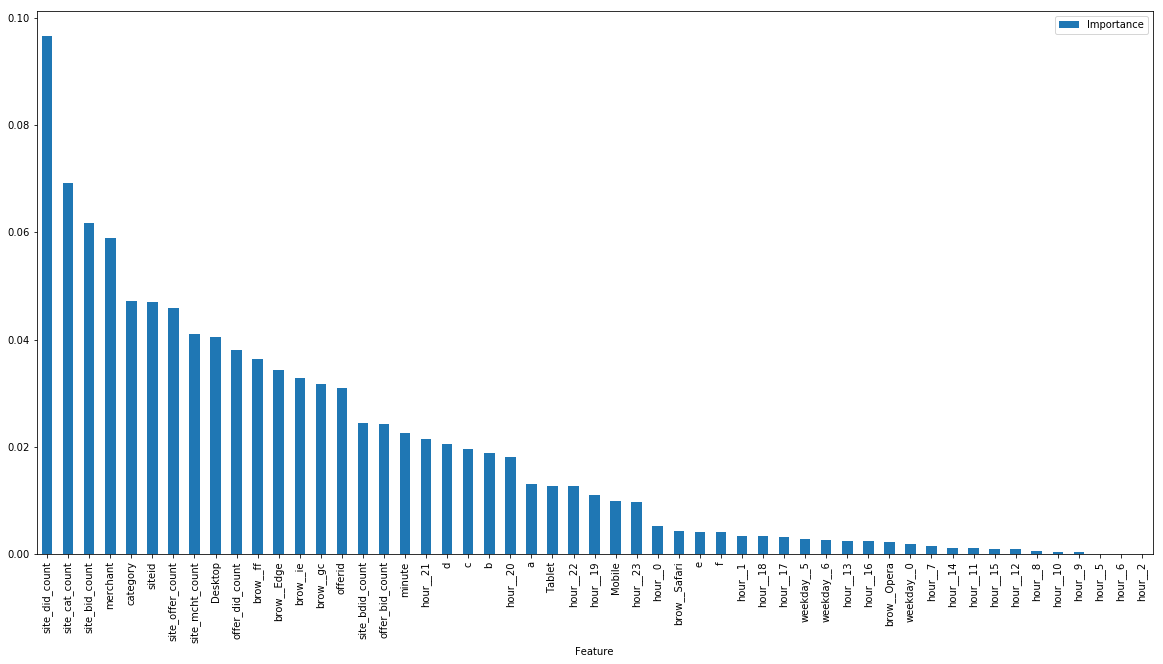

In [27]:
feature_importance = pd.Series(xgb.feature_importances_)
feature_ser = pd.Series(features)
lis = pd.Series(feature_importance.values,index = feature_ser)
lis = sorted(lis.items(),key =lambda x:(-x[1],x[0]))
df = pd.DataFrame(lis, columns=['Feature', 'Importance'])
df.plot(kind='bar',x='Feature',figsize=(20,10))

In [19]:
xgb.fit(train[features],train['click'])
print('fitting is done')

fitting is done


In [20]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.01, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=7, missing=None,
       n_estimators=1000, nthread=4, objective='binary:logistic',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2017,
       silent=True, subsample=0.8)

In [28]:
pred = xgb.predict_proba(test[features])
print('prediction is done')
sub = pd.DataFrame({'ID':test['ID'],'click':pred[:,1]})
sub.to_csv('xgb.csv', index=False)
print('writting is done.')

prediction is done
writting is done.
